In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
opj = os.path.join
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from prfpy_csenf.fit import CSenFFitter
from prfpy_csenf.model import CSenFModel
# from prfpy_csenf.rf import *

from dag_prf_utils.prfpy_functions import *
from dag_prf_utils.plot_functions import *

from ncsf_python.utils import *
from ncsf_python.csf_stimuli import * # import stimulus & basic settings...
from ncsf_python.load_saved_info import *
from ncsf_python.plot_functions import *


np.random.seed(0)

g_noise_reps = 100 #100 # number of repetitions for the gaussian noise simulations. Lower for faster
# Add noise to create simulated timecourses
g_noise_levels = {
    'low'   : 0.4,
    'medium': 0.7,
    'high'  : 1.1,
    }
edge_type = 'CRF'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Error importing pycortex... Not a problem unless you want to use pycortex stuff


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dpu_packages/prfpy_csenf/prfpy_csenf/stimulus.py:252: RuntimeWarning: divide by zero encountered in log10
  self.log_SF_seq = np.log10(self.SF_seq)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dpu_packages/prfpy_csenf/prfpy_csenf/stimulus.py:253: RuntimeWarning: divide by zero encountered in divide
  self.CON_S_seq  = 100/self.CON_seq


Number of timepoints: 214
Number of unique SF levels: 6, [ 0.5  1.   3.   6.  12.  18. ]
Number of unique CON levels: 14, [ 0.25   0.39   0.607  0.946  1.475  2.299  3.582  5.583  8.701 13.56
 21.134 32.937 51.332 80.   ]


# Make the stimulus versions

In [2]:
SF_levels = [ 0.5,  1.,   3.,   6.,  12.,  18. ] 

def create_sequence(n_c_steps, n_c_rep, **kwargs):
    # we want blank down-SF1, up-SF2, blank, ...
    SF_list = [3, 18, 1, 6, 0.5, 12, 6, 1, 12, 3, 18, 0.5] # pseudo random...
    con_list = np.repeat(
        np.logspace(np.log10(0.25), np.log10(80), n_c_steps),
        n_c_rep
        )
    con_list = [i for i in con_list]
    n_blanks = kwargs.get('n_blanks', 10)

    sf_seq = []
    con_seq = []
    i_TYPE = 0
    while len(SF_list) > 0:
        if i_TYPE == 0:
            # Blanks
            sf_seq += [0] * n_blanks
            con_seq += [0] * n_blanks
        elif i_TYPE == 1:
            # DOWN
            this_SF = SF_list.pop(0)
            sf_seq += [this_SF] * len(con_list)
            con_seq += con_list[::-1]
        elif i_TYPE == 2:
            # UP
            this_SF = SF_list.pop(0)
            sf_seq += [this_SF] * len(con_list)
            con_seq += con_list
            i_TYPE = -1
        i_TYPE += 1
    sf_seq += [0] * n_blanks
    con_seq += [0] * n_blanks
    # print(sf_seq)
    # print(con_seq)
    csenf_stim = CSenFStimulus(
        SF_seq  = np.array(sf_seq),
        CON_seq = np.array(con_seq),
        TR=1.5, 
        )
    return csenf_stim


Mcsenf_stim = {}
# Mcsenf_stim['actual'] = CSenFStimulus(
#         SF_seq  = sfs_seq,
#         CON_seq = con_seq,
#         TR=1.5, 
#         )
Mcsenf_stim['S07'] = create_sequence(7, 1)
Mcsenf_stim['S14'] = create_sequence(14, 1)
Mcsenf_stim['S28'] = create_sequence(28, 1)
stim_vers = list(Mcsenf_stim.keys())

Number of timepoints: 154
Number of unique SF levels: 6, [ 0.5  1.   3.   6.  12.  18. ]
Number of unique CON levels: 7, [ 0.25   0.654  1.71   4.472 11.696 30.589 80.   ]
Number of timepoints: 238
Number of unique SF levels: 6, [ 0.5  1.   3.   6.  12.  18. ]
Number of unique CON levels: 14, [ 0.25   0.39   0.607  0.946  1.475  2.299  3.582  5.583  8.701 13.56
 21.134 32.937 51.332 80.   ]
Number of timepoints: 406
Number of unique SF levels: 6, [ 0.5  1.   3.   6.  12.  18. ]
Number of unique CON levels: 28, [ 0.25   0.31   0.383  0.475  0.588  0.728  0.901  1.115  1.381  1.71
  2.117  2.622  3.246  4.019  4.976  6.162  7.629  9.446 11.696 14.482
 17.931 22.202 27.49  34.037 42.144 52.182 64.611 80.   ]


# Set the ground truth parameters

In [3]:
# V1 change only the CRF exp...
n_models = 4
GT_params = {
    #                                 GREEN     RED    CYAN    BLUE
    'width_r'           : np.array([   1.30,   1.00,   1.00,   1.00,]),
    'SFp'               : np.array([   1.00,   2.00,   2.00,   2.00,]),
    'CSp'               : np.array([ 150.00, 100.00, 100.00, 100.00,]),
    'crf_exp'           : np.array([   1.50,   1.50,   1.50,   3.00,]),
    'width_l'           : np.array([   0.68,   0.68,   0.68,   0.68,]),
    'amp_1'             : np.array([   1.00,   1.00,   1.00,   1.00,]),
    'bold_baseline'     : np.array([   0.00,   0.00,   0.00,   0.00,]),
    'hrf_1'             : np.array([   1.00,   1.00,   1.00,   1.00,]),
    'hrf_2'             : np.array([   0.00,   0.00,   0.00,   0.00,]),
    }
edge_type = 'CRF'

# # V2 Make a grid 
# gt_grid = {
#     'width_r'           : np.linspace(0.5, 1.5,                     2),
#     'SFp'               : np.linspace(0.5, 5,                       2),
#     'CSp'               : np.logspace(np.log10(50), np.log10(100),  2),
#     'width_l'           : np.array([0.68]),
#     'crf_exp'           : np.linspace(0.5, 5,                       3),
#     'amp_1'             : np.array([1.0]),
#     'bold_baseline'     : np.array([0.0]),
#     'hrf_1'             : np.array([1.0]),
#     'hrf_2'             : np.array([0.0]),
# }
# gt_keys = list(gt_grid.keys())
# # Now do meshgrid
# gt_mesh = np.meshgrid(*[gt_grid[k] for k in gt_grid.keys()])
# GT_params = {k: v.flatten() for k, v in zip(gt_keys, gt_mesh)}
# print(GT_params['width_r'].shape)
# n_models = len(GT_params['width_r'])

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dpu_packages/prfpy_csenf/prfpy_csenf/rf.py:272: RuntimeWarning: divide by zero encountered in log10
  log_SF_seq  = np.log10(SF_seq)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dpu_packages/prfpy_csenf/prfpy_csenf/rf.py:316: RuntimeWarning: divide by zero encountered in divide
  cthresh_values = 100/csenf_values


[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]


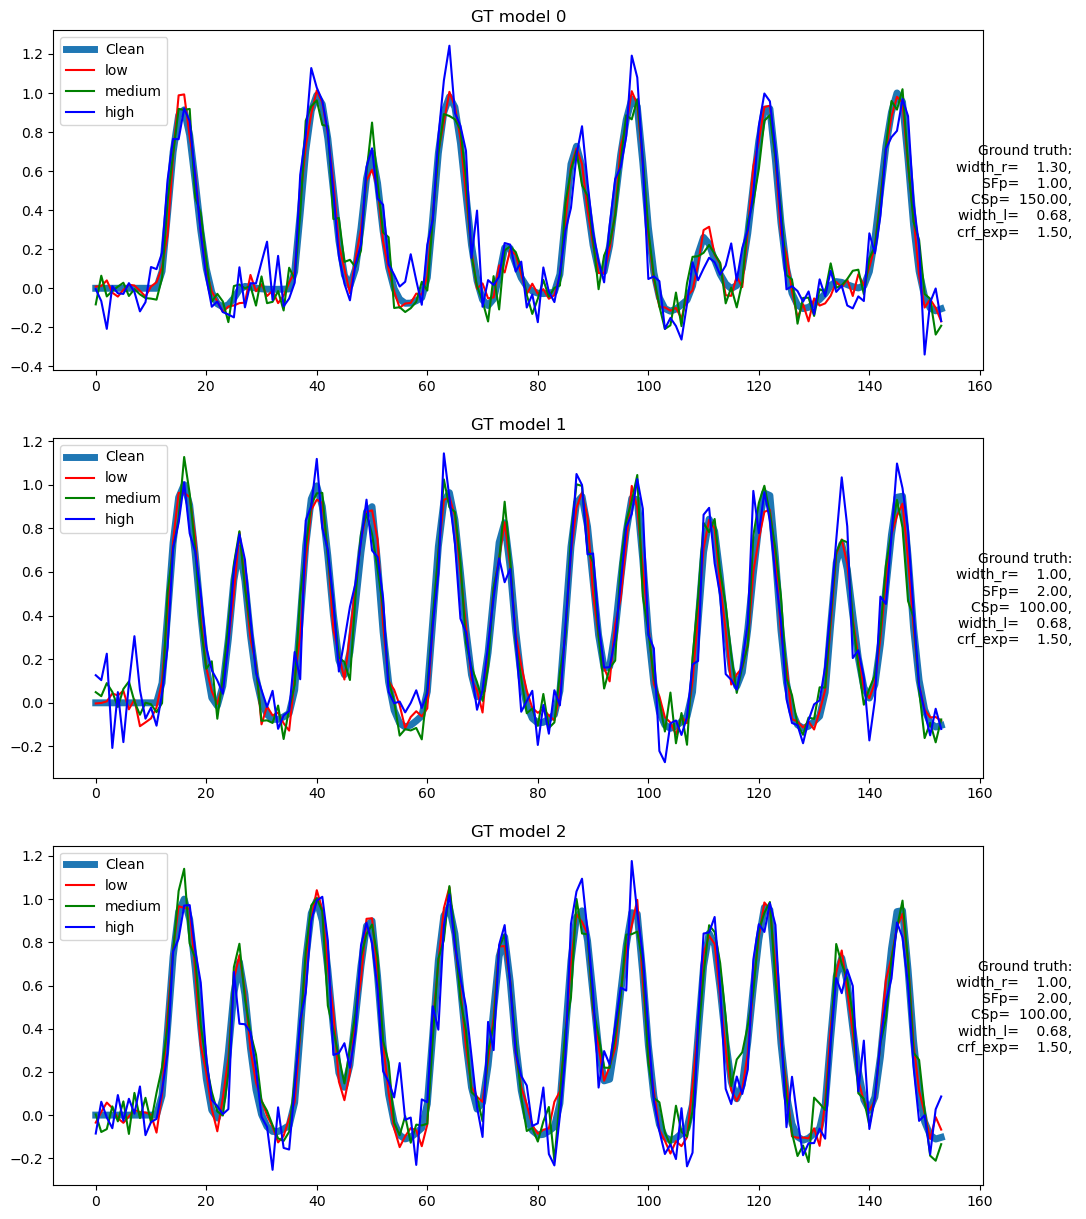

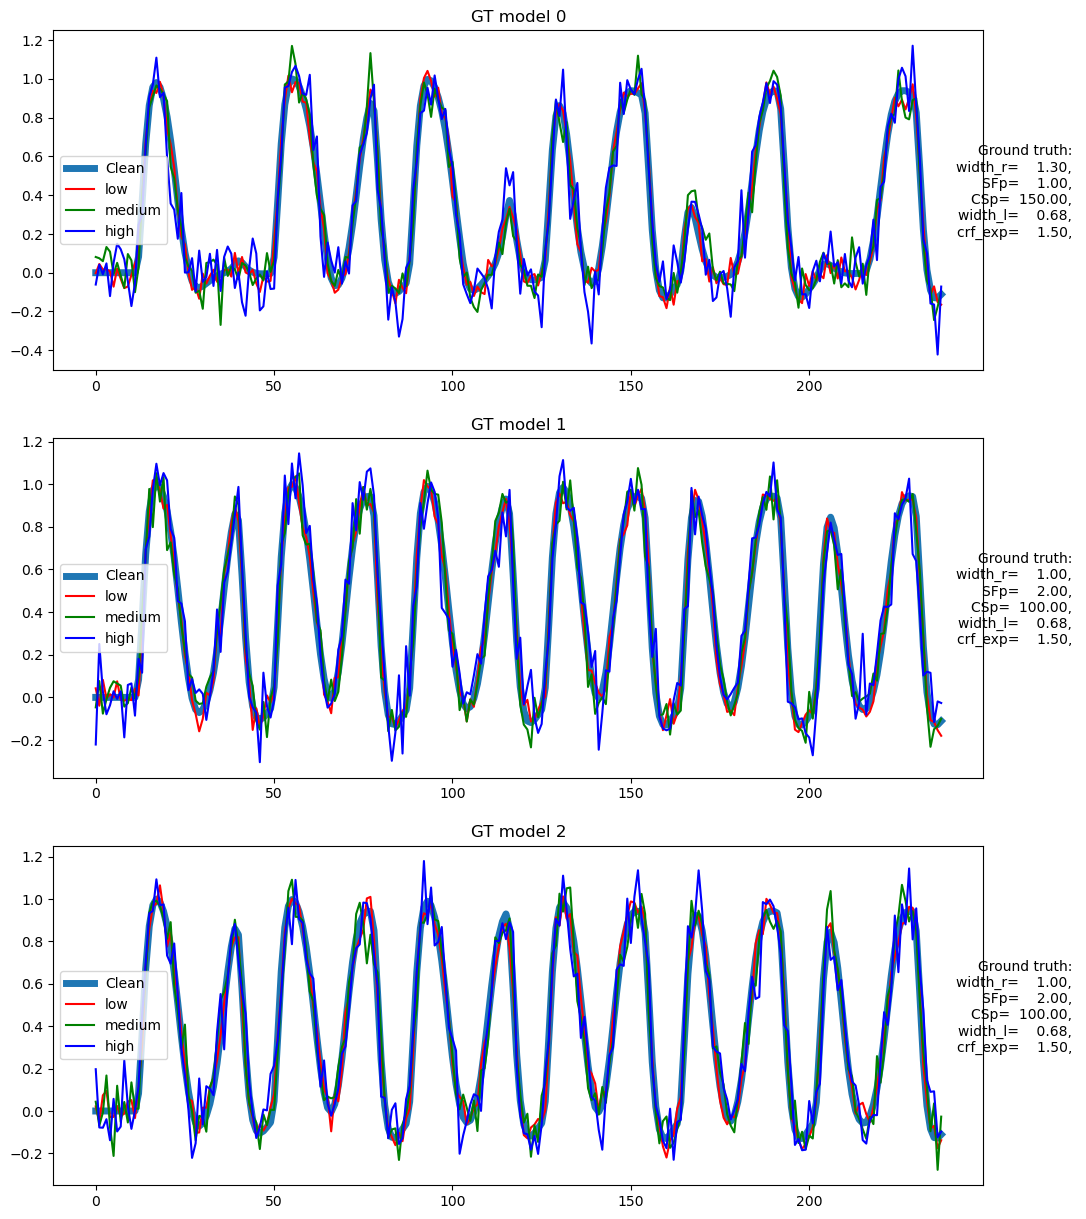

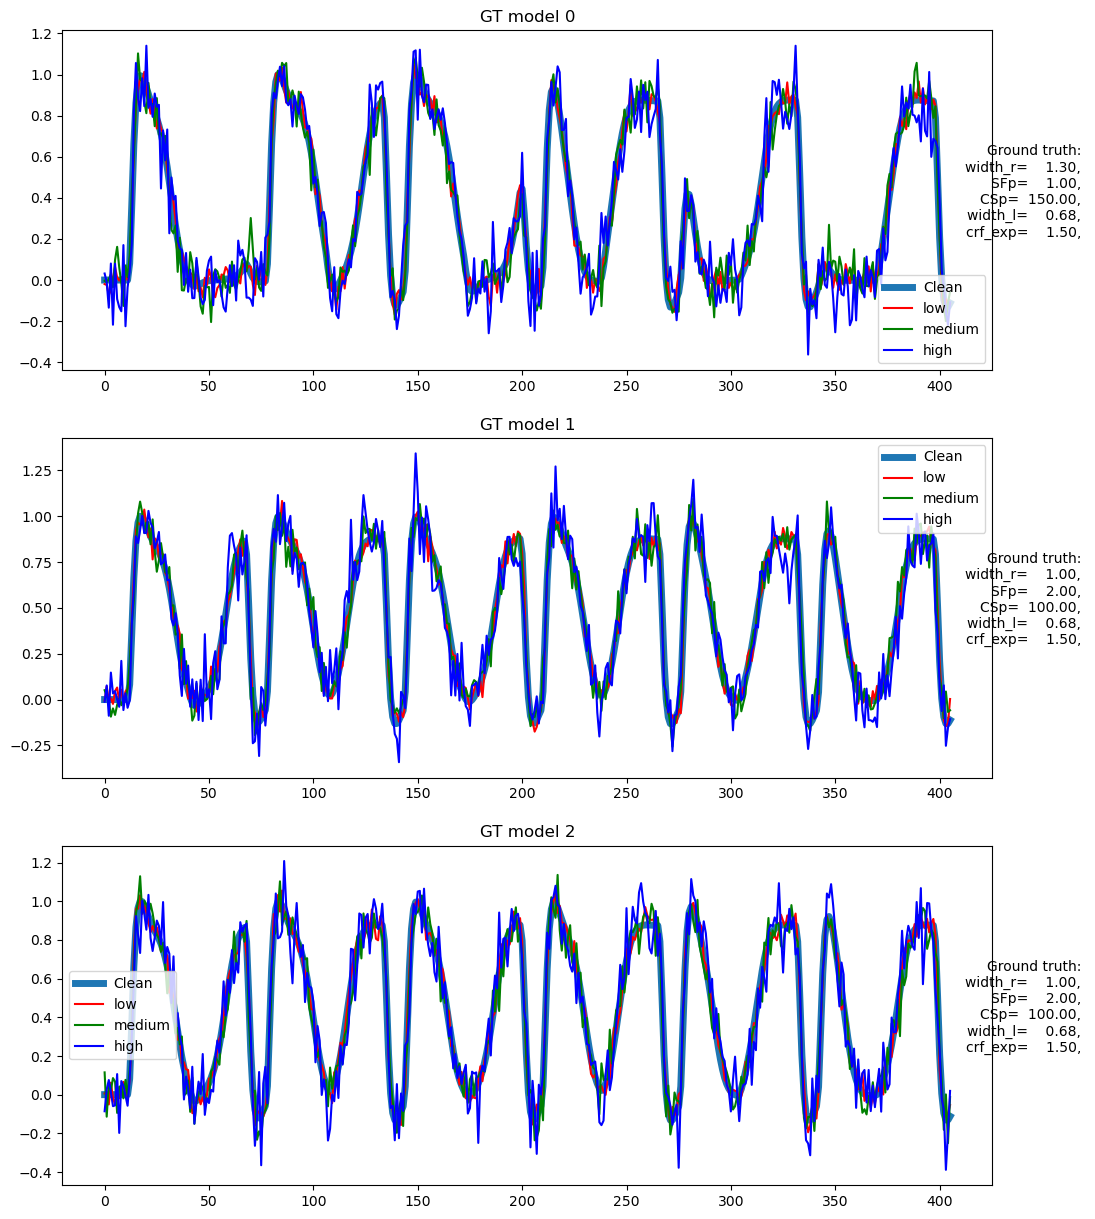

In [4]:
%matplotlib inline

max_val = 1.0 # 
Mcsenf_model = {}
MGT_params = {}
MGT_ts_clean = {}
MGT_ts_noise = {}
for stim in stim_vers:
    MGT_params[stim] = deepcopy(GT_params)
for stim in stim_vers:    
    
    Mcsenf_model[stim] = CSenFModel(
        stimulus = Mcsenf_stim[stim],
        edge_type=edge_type,
        hrf = [1,1,0]
    )
    

    pre_fix_amp1 = Mcsenf_model[stim].return_prediction(
        width_r     = MGT_params[stim]['width_r'],
        SFp         = MGT_params[stim]['SFp'],
        CSp         = MGT_params[stim]['CSp'],
        width_l     = MGT_params[stim]['width_l'],                          
        crf_exp     = MGT_params[stim]['crf_exp'],
        beta        = MGT_params[stim]['amp_1'],
        baseline    = MGT_params[stim]['bold_baseline'],
        )
    for i in range(pre_fix_amp1.shape[0]):
        MGT_params[stim]['amp_1'][i] = max_val / np.max(pre_fix_amp1[i, :])

    MGT_ts_clean[stim] = Mcsenf_model[stim].return_prediction(
        width_r     = MGT_params[stim]['width_r'],
        SFp         = MGT_params[stim]['SFp'],
        CSp         = MGT_params[stim]['CSp'],
        width_l     = MGT_params[stim]['width_l'],                          
        crf_exp     = MGT_params[stim]['crf_exp'],
        beta        = MGT_params[stim]['amp_1'],
        baseline    = MGT_params[stim]['bold_baseline'],
        )    
    print(np.max(MGT_ts_clean[stim], axis=1))


    # Add noise to create simulated timecourses
    MGT_ts_noise[stim] = []
    n_timepoints = MGT_ts_clean[stim].shape[1]
    csf_model_index = []                    # list to store index of parameter set for each timecourse
    noise_index = []
    for g_noise_label,g_noise_value in g_noise_levels.items():
        for i_model in range(GT_params['width_r'].size):
            # g_noise = np.random.normal(0, g_noise_value, (g_noise_reps, n_timepoints))            
            g_noise = np.random.normal(0, 1, (g_noise_reps, n_timepoints)) * g_noise_value
            MGT_ts_noise[stim].append(MGT_ts_clean[stim][i_model,:] + g_noise)        
            csf_model_index.append([i_model] * g_noise_reps)
            noise_index.append([g_noise_label] * g_noise_reps)
    MGT_ts_noise[stim] = np.vstack(MGT_ts_noise[stim])
    csf_model_index = np.hstack(csf_model_index)
    noise_index = np.hstack(noise_index)




    # SANITY CHECKS:
    n2show = np.min([n_models, 3])
    noise_col = ['r', 'g', 'b']
    fig,axs = plt.subplots(n2show,1, figsize=(12, 5*n2show))
    for i_gt in range(n2show):
        ax = axs[i_gt]
        # Plot the clean timecourse
        ax.plot(MGT_ts_clean[stim][i_gt,:], lw=5, label='Clean')

        for g_noise_id,g_noise_label in enumerate(g_noise_levels.keys()):
            i_noise = np.where(
                (csf_model_index==i_gt) & (noise_index==g_noise_label)
                )[0]
                        
            ax.plot(
                MGT_ts_noise[stim][i_noise,:].mean(axis=0).T, label=g_noise_label, color=noise_col[g_noise_id])
        
        ax.legend()        
        ax.set_title(f'GT model {i_gt}')

        gt_txt = 'Ground truth: \n' + \
            f'width_r={GT_params["width_r"][i_gt]:>8.2f}, \n' + \
            f'SFp={GT_params["SFp"][i_gt]:>8.2f}, \n' + \
            f'CSp={GT_params["CSp"][i_gt]:>8.2f}, \n' + \
            f'width_l={GT_params["width_l"][i_gt]:>8.2f}, \n' + \
            f'crf_exp={GT_params["crf_exp"][i_gt]:>8.2f}, \n'
        # Add text to outside right of plot
        # Use monospaced font
        ax.text(
            1.1, 0.5, gt_txt, transform=ax.transAxes, 
            fontsize=10, va='center', ha='right',
            # family='monospace',
            )


### Fit the noisy simulated data

In [7]:
fit_settings = load_yml_settings()
bounds = {**fit_settings['csf_bounds']}
bounds_plt = {
    **fit_settings['csf_bounds'],
    'sfmax'         : [0, 50], 
    'rsq'           : [0, 1],
    'aulcsf'        : [0, 3],
    'ncsf_volume'   : [0, 1],
    'noise_ceil'    : [0, 1],
}
# [2] Setup grids:
grid_nr = 15 # number of steps in grid
width_r_grid    = np.linspace(bounds['width_r'][0], bounds['width_r'][1], grid_nr)     
SFp_grid        = np.linspace(bounds['SFp'][0], bounds['SFp'][1], grid_nr)     
CSp_grid       = np.linspace(bounds['CSp'][0], bounds['CSp'][1], grid_nr)
width_l_grid    = np.array(bounds['width_l'][0])
crf_exp_grid    = np.linspace(bounds['crf_exp'][0], bounds['crf_exp'][1], grid_nr)

hrf_1_grid = None
hrf_2_grid = None
# -> & grid bounds
csf_grid_bounds = [bounds['amp_1']]

# [3] Setup iterative bounds
bounds_list = [
    (bounds['width_r']),     # width_r
    (bounds['SFp']),     # SFp
    (bounds['CSp']),    # CSp
    (bounds['width_l']),     # width_l
    (bounds['crf_exp']),     # crf_exp
    (bounds['amp_1']),   # amp_1
    (bounds['bold_baseline']),      # baseline
    (bounds['hrf_1']),      # baseline
    (bounds['hrf_2']),      # baseline
]
# -> Constraints determines which scipy fitter is used
csf_constraints = None   # None -> bgfs, [] -> TC


In [7]:
# [4] Loop through noise levels and fit simulated data
# Make fitter object
n_jobs = 10
reco_param = {}
for stim in stim_vers:
    csenf_fitter = CSenFFitter(
        data    = MGT_ts_noise[stim],
        model   = Mcsenf_model[stim],
        n_jobs=n_jobs,
    )
    # Start grid fit
    csenf_fitter.grid_fit(
        width_r_grid    = width_r_grid,
        SFp_grid        = SFp_grid,
        CSp_grid       = CSp_grid,
        width_l_grid    = width_l_grid,
        crf_exp_grid    = crf_exp_grid,
        hrf_1_grid      = hrf_1_grid,
        hrf_2_grid      = hrf_2_grid,
        verbose         = False,
        fixed_grid_baseline=False,
        grid_bounds=csf_grid_bounds, 
        n_batches=n_jobs,
    )


    # Start iterative fit
    csenf_fitter.iterative_fit(
        rsq_threshold = 0.1,            
        verbose = False,
        bounds = bounds_list,
        constraints = csf_constraints,
        xtol=0.0001,   
        ftol=0.0001,           
        )

    # # Store recovered parameters in dict
    reco_param[stim] = csenf_fitter.iterative_search_params


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/model.py:987: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prediction_params = np.array([width_r,
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:272: RuntimeWarning: divide by zero encountered in log10
  log_SF_seq  = np.log10(SF_seq)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:316: RuntimeWarning: divide by zero encountered in true_divide
  cthresh_values = 100/csenf_values
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimen

# SIMPLIFIED ...

In [8]:
csf_idx_dict = {
    'width_r'       : 0,
    'SFp'           : 1,
    'CSp'          : 2,
    'width_l'       : 3,
    'crf_exp'       : 4,
    'amp_1'         : 5,
    'bold_baseline' : 6,
    'hrf_1'         : 7,
    'hrf_2'         : 8,
    'rsq'           : -1,
}

reco_dict = {}
reco_obj = {}
GT_obj = {}
for stim in stim_vers:
    reco_dict[stim] = {}
    for p in csf_idx_dict.keys():
        reco_dict[stim][p] = reco_param[stim][:,csf_idx_dict[p]]


    reco_obj[stim] = CSenFPlotter(
        prf_params=reco_dict[stim],
        real_ts = MGT_ts_noise[stim], 
        prfpy_model = Mcsenf_model[stim],
    )
    GT_obj[stim] = CSenFPlotter(
        prf_params=GT_params,
        # real_ts = MGT_ts_noise[stim], 
        prfpy_model = Mcsenf_model[stim],
    )



/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:180: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_SFp'] = np.log10(self.params_dd['SFp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:181: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_CSp'] = np.log10(self.params_dd['CSp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:182: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_crf_exp'] = np.log10(self.params_dd['crf_exp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:40: RuntimeWarning: divide by zero encountered in log10
  log10_CSp = np.log10(CSp)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:41: RuntimeWarning: divid

# Same format as in original simulations: 
but with different rows; not 

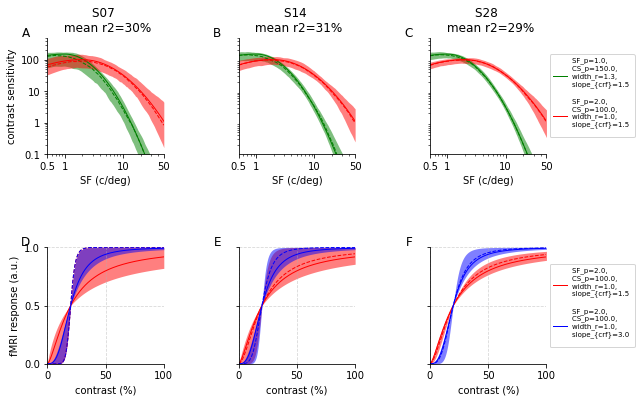

In [9]:
rsq_th = 0.1
ncsf_gt_col = {
    0 : 'green',
    1 : 'red',
    2 : 'red', # because it is actually the same...
    3 : 'blue',

}

CRF_kwargs = {
    'ow_Qs' : True,
    'sf_for_crf' : None,
    'do_log' : False,
    'Qs_at_CSp' : False,
}
n_row = 2
n_col = 3
fig, axs = plt.subplots(
    n_row, n_col,
    figsize=(9,6)
)
# fig.set_tight_layout(True)
# Adding subfigure labels (A, B, C, etc.)
for i_row in range(n_row):
    for iP in range(n_col):
        label = string.ascii_uppercase[i_row * n_col + iP]  # A, B, C, ...
        axs[i_row, iP].text(-0.15, 1.1, label, transform=axs[i_row, iP].transAxes,
                            fontsize=12, va='top', ha='right')

# - make sure it doesn't overlap with the plots
# fig.subplots_adjust(top=0.85)
# [1] nCSF plots
for i_gt in [0,1]:
    gt_index = csf_model_index==i_gt
    for i_ax,stim in enumerate(stim_vers):
        gt_rsq_index = gt_index & (reco_obj[stim].pd_params['rsq'] > rsq_th)
        gt_rsq_index = np.where(gt_rsq_index)[0]
        
        # *********** Plot recovered CSF curves *********** 
        # *************************************************
        # Setup the axis
        ax = axs[0][i_ax]
        # PLOT GROUND TRUTH ****
        this_label = f'SF_p={GT_params["SFp"][i_gt]:>.1f}, \n' + \
            f'CS_p={GT_params["CSp"][i_gt]:>.1f}, \n' + \
            f'width_r={GT_params["width_r"][i_gt]:>.1f}, \n' + \
            'slope_{crf}' + f'={GT_params["crf_exp"][i_gt]:>.1f} \n'  
        
        this_params = GT_obj[stim].pd_params.iloc[i_gt]
        ncsfplt_csf_curve(
            params=this_params,
            # csf_obj=GT_obj,            
            # idx=i_gt, 
            ax=ax,
            line_col=ncsf_gt_col[i_gt],
            linewidth=2, 
            line_label=this_label,         
            add_extrapolated=False,    
        )
        # bloop
        # ***

        # PLOT RECOVERED PARAMETERS
        this_params = reco_obj[stim].pd_params.iloc[gt_rsq_index]
        ncsfplt_csf_curve(
            params=this_params,
            # csf_obj=reco_obj,
            # idx=gt_rsq_index,
            ax=ax,
            line_col=ncsf_gt_col[i_gt],
            label='_',     
            add_extrapolated=False,   
            line_kwargs = {'linestyle':'--'},
        )
        
        
        m_rsq = np.mean(reco_obj[stim].pd_params['rsq'][gt_rsq_index])
        # print(m_rsq)
        ax.set_title(f'{stim} \n mean r2={m_rsq*100:.0f}%')
        if i_ax!=0:
            ax.set_ylabel('')
            ax.set_yticks([])
        if (i_ax==2):
            ax.legend(
                fontsize=7, loc='center left', 
                bbox_to_anchor=(1,0.5), 
                )

# [1] nCSF plots
for i_gt in [2,3]:
    gt_index = csf_model_index==i_gt
    for i_ax,stim in enumerate(stim_vers):
        gt_rsq_index = gt_index & (reco_obj[stim].pd_params['rsq'] > rsq_th) 
        gt_rsq_index = np.where(gt_rsq_index)[0]

        # *********** Plot recovered CRF curves *********** 
        # *************************************************
        contrast_pc = np.linspace(0, 100, 100)        
        # Setup the axis
        ax = axs[1][i_ax]

        this_label = '' + \
            f'SF_p={GT_params["SFp"][i_gt]:>.1f}, \n' + \
            f'CS_p={GT_params["CSp"][i_gt]:>.1f}, \n' + \
            f'width_r={GT_params["width_r"][i_gt]:>.1f}, \n' + \
            'slope_{crf}' + f'={GT_params["crf_exp"][i_gt]:>.1f} \n'  

        this_params = GT_obj[stim].pd_params.iloc[i_gt]
        ncsfplt_crf_curve(
            params=this_params,
            # csf_obj=GT_obj,
            # idx=i_gt, 
            ax=ax,
            line_col=ncsf_gt_col[i_gt],
            linewidth=2, 
            line_label=this_label,
            **CRF_kwargs            

        )
        # ***

        # PLOT RECOVERED PARAMETERS
        this_params = reco_obj[stim].pd_params.iloc[gt_rsq_index]
        ncsfplt_crf_curve(
            params=this_params,
            # csf_obj=reco_obj,
            # idx=gt_rsq_index, 
            ax=ax,
            line_col=ncsf_gt_col[i_gt],
            line_label='_',     
            line_kwargs = {'linestyle':'--'},      
            **CRF_kwargs                        
        )        
        if i_ax!=0:
            ax.set_ylabel('')
            ax.set_yticklabels(['','',''])
        if (i_ax==2):
            ax.legend(
                fontsize=7, loc='center left', 
                bbox_to_anchor=(1,0.5), 
                )
            # ax.legend() #loc='center left', bbox_to_anchor=(1,0.5), ) #justify=(1,0))        

fig.subplots_adjust(
    hspace=0.8,
    wspace=0.6,
    )      

fig_saver.add_img(fig, fig_name='sim_curves')


## ORIGINAL - swwarms...

0, col=green, true val aulcsf = 74.6374
0, col=green, true val SFp = 1.0000
0, col=green, true val CSp = 150.0000
0, col=green, true val crf_exp = 1.5000
1, col=red, true val aulcsf = 91.2839
1, col=red, true val SFp = 2.0000
1, col=red, true val CSp = 100.0000
1, col=red, true val crf_exp = 1.5000
2, col=red, true val aulcsf = 91.2839
2, col=red, true val SFp = 2.0000
2, col=red, true val CSp = 100.0000
2, col=red, true val crf_exp = 1.5000
3, col=blue, true val aulcsf = 91.2839
3, col=blue, true val SFp = 2.0000
3, col=blue, true val CSp = 100.0000
3, col=blue, true val crf_exp = 3.0000


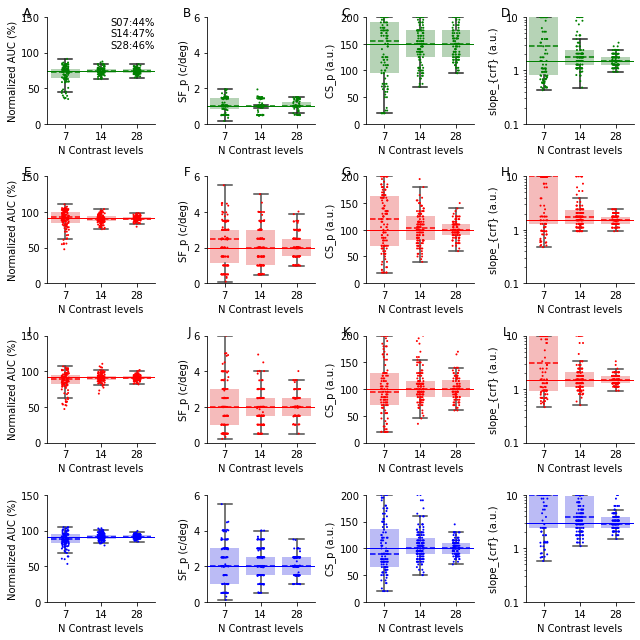

In [10]:
def sim_swarm_plots(p2plot, do_crf_log=False):    
    prop = 4/len(p2plot)
    fig, axs = plt.subplots(
        4, len(p2plot),
        figsize=(9*prop, prop*9),
    )
    fig.set_tight_layout(True)
    plt.subplots_adjust(hspace=0.5)
    p2plot_nice = {
        'sfmax': 'SF_{max} (c/deg)',
        'aulcsf': 'Normalized AUC (%)',
        'SFp': 'SF_p (c/deg)',
        'CSp': 'CS_p (a.u.)',
        'crf_exp': 'slope_{crf} (a.u.)',
        'width_r': 'width_r (a.u.)',
    }

    # Adding subfigure labels (A, B, C, etc.)
    for i_row in range(3):
        for iP in range(len(p2plot)):
            label = string.ascii_uppercase[i_row * len(p2plot) + iP]  # A, B, C, ...
            axs[i_row, iP].text(-0.15, 1.1, label, transform=axs[i_row, iP].transAxes,
                                fontsize=12, va='top', ha='right')

    for i_row, i_gt in enumerate([0, 1, 2, 3]):
        gt_index = csf_model_index == i_gt
        # ***************************************************************************************************************
        # ****************************************** SWARM PLOTS ********************************************************            
        # Make mrsq labels
        m_labels = ''
        for level in stim_vers:
            gt_rsq_index = gt_index & (reco_obj[level].pd_params['rsq'] > rsq_th) 
            gt_rsq_index = np.where(gt_rsq_index)[0]            
            mrsq = np.mean(
                reco_obj[level].pd_params['rsq'][gt_rsq_index]
                )
            m_labels += f'{level}:{mrsq*100:.0f}%\n'
            


        sw_ax = axs[i_row]
        # Loop through ps for swarm plot
        for iP,param in enumerate(p2plot):    
            if (i_row==0) & (iP==0):
                # Add mean rsq by level info
                sw_ax[iP].text(1, 1, m_labels, transform=sw_ax[iP].transAxes, ha='right', va='top')

            # sns.swarm plot of {param}, split by noise level. Colors of each level determined by g_noise_cols
            # -> with labels on x-axis
            # -> make data frame for data
            data = {
                'stim' : [],
                'param'  : [],
            }
            for stim in stim_vers:
                gt_rsq_index = gt_index & (reco_obj[stim].pd_params['rsq'] > rsq_th)
                gt_rsq_index = np.where(gt_rsq_index)[0]
                
                data['stim'] += [stim] * len(gt_rsq_index)
                data['param'] += reco_obj[stim].pd_params[param][gt_rsq_index].tolist()

            data = pd.DataFrame(data)
            # Strip plot, with colors determined by noise_cols
            sns.stripplot(
                data = data,
                ax = sw_ax[iP],
                color = ncsf_gt_col[i_gt],
                x = 'stim',
                y = 'param',
                size=2,
                )
            
            # Also sns boxplot, displaying same data as in the swarmplot
            # -> but a little bit transparent
            sns.boxplot(
                data = data,
                ax = sw_ax[iP],
                color = ncsf_gt_col[i_gt],
                boxprops=dict(alpha=.3, linewidth=0),
                medianprops=dict(color=ncsf_gt_col[i_gt], linestyle='dashed'),
                showfliers=False,
                x = 'stim',
                y = 'param',
                
                
                )
            # Set ylim to bounds of parameter
            sw_ax[iP].set_ylim(bounds[param])
            if param=='sfmax':
                sw_ax[iP].set_ylim(0, 100)
            elif param=='aulcsf':
                sw_ax[iP].set_ylim(0, 150)
                
            if do_crf_log & (param=='crf_exp'):
                sw_ax[iP].set_ylim([0.1, 10])
                sw_ax[iP].set_yscale('log')
                sw_ax[iP].set_yticks([0.1, 1, 10])
                sw_ax[iP].set_yticklabels(['0.1', '1', '10'])

            sw_ax[iP].set_xlabel(f'')        
            sw_ax[iP].set_ylabel(p2plot_nice[param])
            sw_ax[iP].axhline(
                GT_obj[stim].pd_params[param][i_gt], 
                color = ncsf_gt_col[i_gt],
                lw=1,
                )
            print(f'{i_gt}, col={ncsf_gt_col[i_gt]}, true val {param} = {GT_obj[stim].pd_params[param][i_gt]:.4f}')
            # if i_row==0:
            #     sw_ax[iP].set_xticklabels('')
            # else:
            sw_ax[iP].set_xticklabels(['7', '14', '28'])
            sw_ax[iP].set_xlabel('N Contrast levels')
            
            sw_ax[iP].spines['right'].set_visible(False)
            sw_ax[iP].spines['top'].set_visible(False)
            sns.despine()
rsq_th = 0.3
p2plot = ['aulcsf', 'SFp', 'CSp', 'crf_exp',] #  'width_r']
sim_swarm_plots(p2plot, do_crf_log=True)
fig_saver.add_img(plt.gcf(), fig_name='swarm_auc_crf_log',)


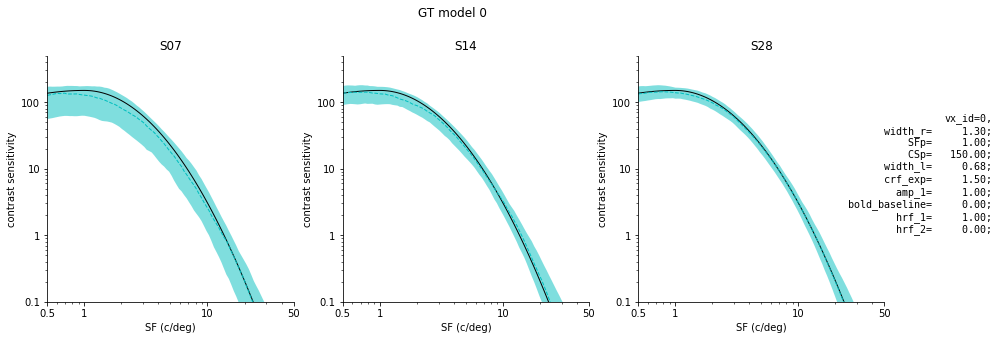

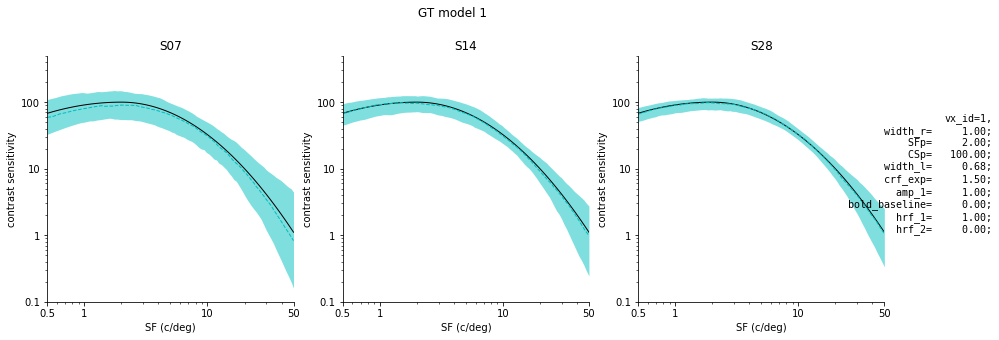

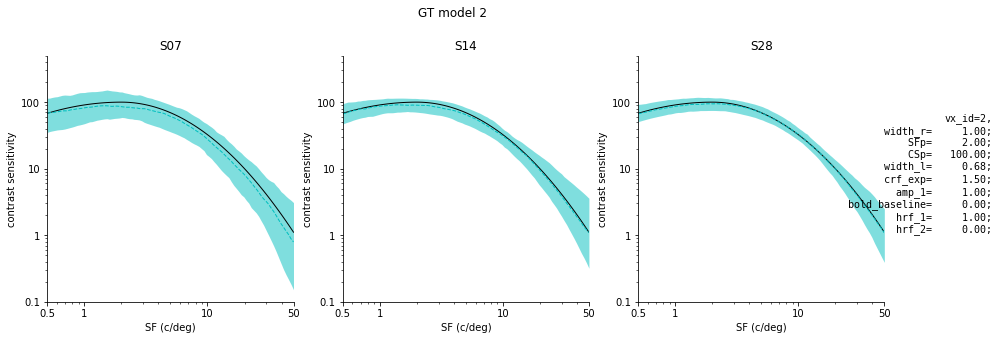

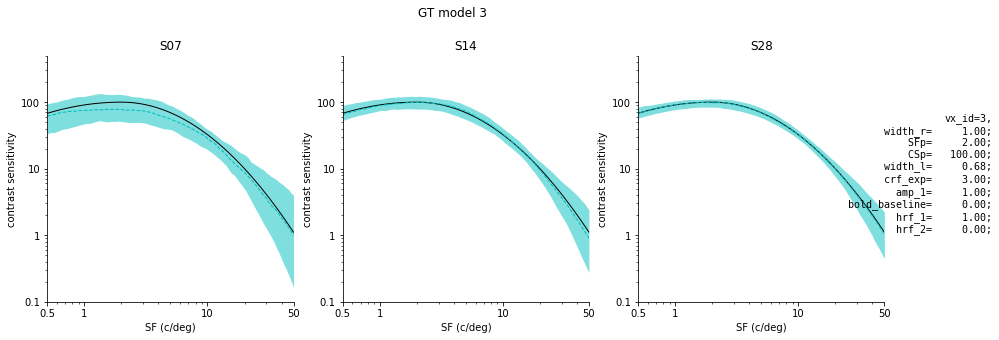

In [11]:
# [1] For GT model, and RSQ threshold, plot CSF
rsq_threshold = 0.1
for gt_id in range(n_models):
    fig,axs = plt.subplots(1,len(stim_vers), figsize=(5*len(stim_vers),5))
    prf_str = GT_obj[stim].make_prf_str(gt_id)
    fig.suptitle(f'GT model {gt_id}')
    # Add text to outside right of plot
    # Use monospaced font
    fig.text(s=prf_str, x=1, y=0.5, transform=fig.transFigure, fontsize=10, va='center', ha='right', family='monospace')    
    gt_index = csf_model_index==gt_id
    for iN,stim in enumerate(stim_vers):
        ax = axs[iN]
        ax.set_title(stim)
            
        this_params = GT_obj[stim].pd_params.iloc[gt_id]
        ncsfplt_csf_curve(
            params=this_params,
            # csf_obj=GT_obj,            
            # idx=i_gt, 
            ax=ax,
            line_col='k',
            linewidth=2, 
            line_label='GROUND',         
            add_extrapolated=False,    
        )

        # Plot the recovered CSF
        gt_rsq_index = gt_index & (reco_obj[stim].pd_params['rsq'] > rsq_threshold) 
        gt_rsq_index = np.where(gt_rsq_index)[0]
        this_params = reco_obj[stim].pd_params.iloc[gt_rsq_index]
        ncsfplt_csf_curve(
            params=this_params,
            # csf_obj=reco_obj,
            # idx=gt_rsq_index,
            ax=ax,
            line_col='c',
            label='_',     
            add_extrapolated=False,   
            line_kwargs = {'linestyle':'--'},
        )
        


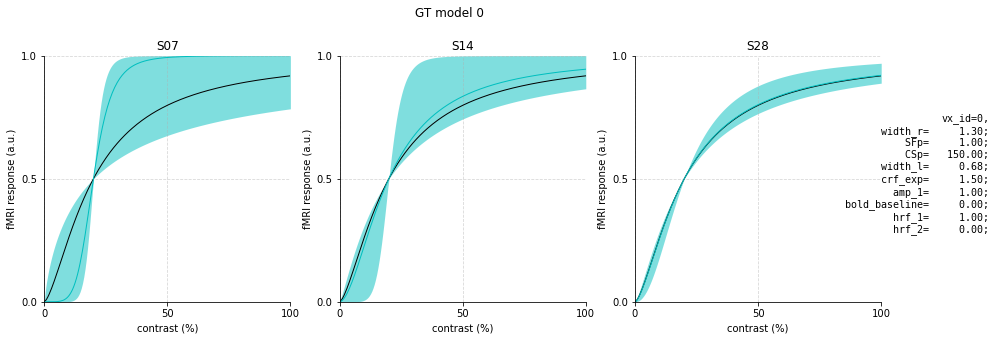

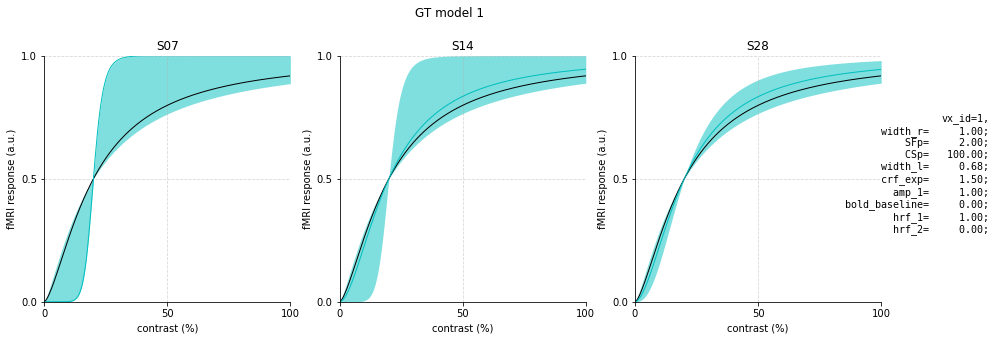

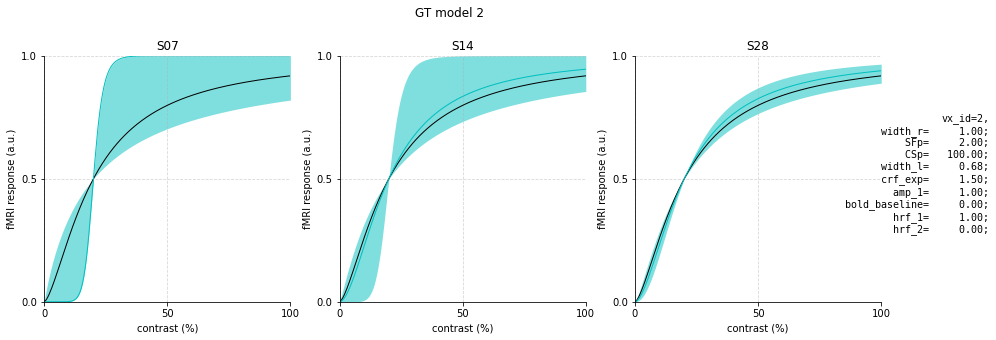

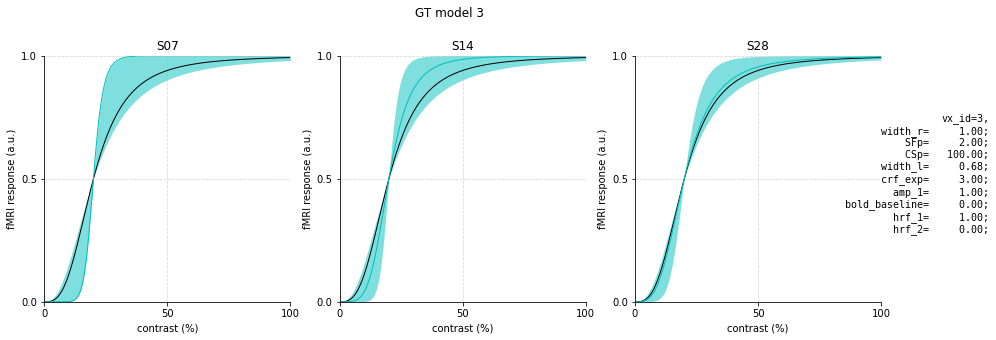

In [12]:
# [1] For GT model, and RSQ threshold, plot CSF
crf_kwargs = {
    'do_log': False,
    'ow_Qs' : True, 
    # 'sf_for_crf' : 12, 

}
for gt_id in range(n_models):
    fig,axs = plt.subplots(1,len(stim_vers), figsize=(5*len(stim_vers),5))
    prf_str = GT_obj[stim].make_prf_str(gt_id)
    fig.suptitle(f'GT model {gt_id}')
    # Add text to outside right of plot
    # Use monospaced font
    fig.text(s=prf_str, x=1, y=0.5, transform=fig.transFigure, fontsize=10, va='center', ha='right', family='monospace')
    gt_index = csf_model_index==gt_id
    for iN,stim in enumerate(stim_vers):
        ax = axs[iN]
        ax.set_title(stim)
            
        this_params = GT_obj[stim].pd_params.iloc[gt_id]
        ncsfplt_crf_curve(
            params=this_params,
            ax=ax,
            line_col='k',
            linewidth=2, 
            line_label='GROUND',
            **crf_kwargs
        )

        # Plot the recovered CSF
        gt_rsq_index = gt_index & (reco_obj[stim].pd_params['rsq'] > rsq_threshold) 
        gt_rsq_index = np.where(gt_rsq_index)[0]
        this_params = reco_obj[stim].pd_params.iloc[gt_rsq_index]
        ncsfplt_crf_curve(
            params=this_params,
            ax=ax,
            line_col='c',
            label='_',     
            **crf_kwargs
        )
        


# Scatter recovered vs input

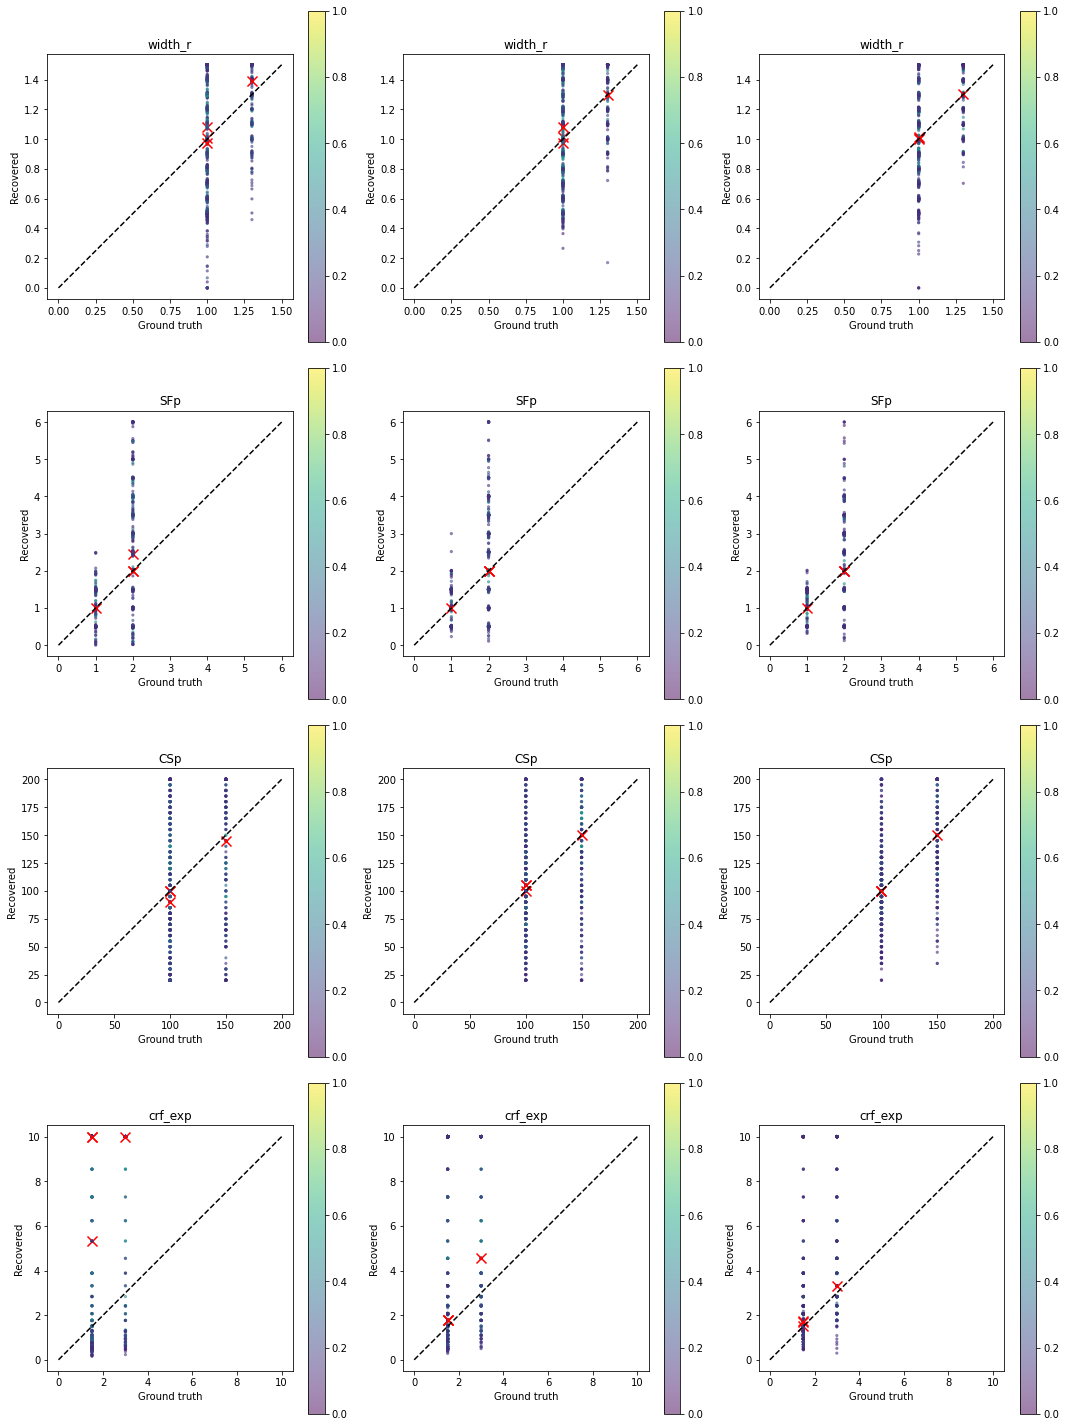

In [13]:
p2plot = ['width_r', 'SFp', 'CSp', 'crf_exp']
fig, axs = plt.subplots(len(p2plot), len(stim_vers), figsize=(5*len(stim_vers), 5*len(p2plot)))
for iN,stim in enumerate(stim_vers):
    for iP,p in enumerate(p2plot):
        ax = axs[iP, iN] # , iN]
        ax.set_title(f'{stim} - {p}')
        for gt_id in range(n_models):
            this_GTparams = GT_obj[stim].pd_params[p][gt_id]
            gt_index = csf_model_index==gt_id
            gt_rsq_index = gt_index & (reco_obj[stim].pd_params['rsq'] > rsq_threshold) 
            gt_rsq_index = np.where(gt_rsq_index)[0]
            this_Recoparams = reco_obj[stim].pd_params[p][gt_rsq_index]
            this_RecoR2 = reco_obj[stim].pd_params['rsq'][gt_rsq_index]
            sca = ax.scatter(
                this_GTparams*np.ones_like(this_Recoparams), 
                this_Recoparams, 
                c=this_RecoR2,
                cmap='viridis',
                vmin=0, vmax=1, s=5,
                alpha=0.5)    
            ax.scatter(
                this_GTparams,
                np.median(this_Recoparams),
                c='r',
                marker='x',
                s=100,
            )        
        # add colorbar
        plt.colorbar(sca, ax=ax)
        ax.plot([bounds[p][0], bounds[p][1]], [bounds[p][0], bounds[p][1]], 'k--')
        ax.set_xlim(bounds[p])
        ax.set_ylim(bounds[p])
        ax.set_xlabel('Ground truth')
        ax.set_ylabel('Recovered')
        ax.set_title(p)
        ax.axis('square')
fig.tight_layout()

# save

In [14]:
save_running_code(opj(fig_saver.path))

<IPython.core.display.Javascript object>

Notebook not saving...
jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/notebooks/n1_simulation_ramp.ipynb --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/simulation_ramp-2024-10-04/n1_simulation_ramp.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/notebooks/n1_simulation_ramp.ipynb to html
[NbConvertApp] Writing 2598760 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/simulation_ramp-2024-10-04/n1_simulation_ramp.html


jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/notebooks/n1_simulation_ramp.ipynb --no-input --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/simulation_ramp-2024-10-04/n1_simulation_ramp_NOCODE.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/notebooks/n1_simulation_ramp.ipynb to html
[NbConvertApp] Writing 2469398 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/simulation_ramp-2024-10-04/n1_simulation_ramp_NOCODE.html
